In [1]:
#google driveとの連携
from google.colab import drive
drive.mount('/content/drive')

#カレントディレクトリの設定
dir_path = '/content/drive/My Drive/Colab Notebooks/repo7'
import os
os.chdir(dir_path)

#モジュール追加用pathの設定
import sys
sys.path.append('..')

#モジュールのインポート
import numpy as np


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**RNNレイヤの実装**\
今まではコンテキスト内の並びが無視されていた。"you say"と"say you"は等価だったがRNNを用いることで並びに対応できる。この並びは時系列データという形で処理される。


In [2]:
class RNN:
  def __init__(self, Wx, Wh, b):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] #勾配の初期化(形状チェック)
    self.cache = None #順伝播結果一時保存用

  def forward(self, x, h_prev):
    Wx, Wh, b = self.params
    t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
    h_next = np.tanh(t)
    self.cache = (x, h_prev, h_next) #順伝播結果一時保存
    return h_next

  def backward(self, dh_next):
    Wx, Wh, x = self.params
    x, h_prev, h_next = self.cache

    dt = dh_next * (1 - h_next ** 2) # tanhの微分
    db = np.sum(dt, axis=0)
    dWh = np.dot(h_prev.T, dt)
    dh_prev = np.dot(dt, Wh.T)
    dWx = np.dot(x.T, dt)
    dx = np.dot(dt, Wx.T)

    self.grads[0][...] = dWx
    self.grads[1][...] = dWh
    self.grads[2][...] = db

    return dx, dh_prev

**Time RNNレイヤの実装**

In [3]:
class TimeRNN:
  def __init__(self, Wx, Wh, b, stateful=False):
    self.params = [Wx, Wh, b]
    self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] #勾配の初期化(形状チェック)
    self.layers = None
    self.h, self.dh = None, None
    self.stateful = stateful

  def set_state(self, h):
    self.h = h
  
  def reset_state(self):
    self.h = None

  def forward(self, xs):
    Wx, Wh, b = self.params
    N, T, D = xs.shape
    D, H = Wx.shape

    self.layers = []
    hs = np.empty((N, T, H), dtype='f') #出力用

    if not self.stateful or self.h is None:
      self.h = np.zeros((N, H), dtype='f')
    
    for t in range(T): #各時系列データに対して
      layer = RNN(*self.params)
      self.h = layer.forward(xs[:, t, :], self.h)
      hs[:, t, :] = self.h
      self.layers.append(layer)

    return hs
  
  def backward(self, dhs):
    Wx, Wh, b = self.params
    N, T, H = dhs.shape
    D, H = Wx.shape

    dxs = np.empty((N, T, D), dtype='f') #出力用
    dh = 0
    grads = [0, 0, 0]
    for t in reversed(range(T)): 
      layer = self.layers[t]
      dx, dh = layer.backward(dhs[:, t, :] + dh)
      dxs[:, t, :] = dx

      for i, grad in enumerate(layer.grads):
        grads[i] += grad

    for i, grad in enumerate(grads):
      self.grads[i][...] = grad
    self.dh = dh

    return dxs

forwardはxs(T個のデータ)バッチ数はNなので各データの次元数Dとすると形状は(N, T, D)となる。\
RNNのレイヤ隠れ状態hはself.h=Noneのときには要素がすべて0の行列で初期化、またstatefulがFalseのときも要素がすべて0の行列で初期化\
forward()が呼ばれるとメンバ変数のhに最終RNNレイヤの隠れ状態が設定される。stateful = Trueのとき次にforwardメソッドが呼ばれるとき、そのメンバ変数hが継続、Falseの場合にはメンバ変数が0行列でリセット\
順伝播は\
$$x_t = h_t + h_n$$
$h_n$は一つ未来のレイヤへの出力なので逆伝播は\
$$dx_t = dh_t + dh_n$$
となる。

In [4]:
import numpy as np
N = 5
T = 15
D = 10
H = 3
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(N, H)

xs = np.random.randn(N, T, D)

timeRNN = TimeRNN(Wx, Wh, b, stateful=True)
hs = timeRNN.forward(xs)
print(hs.shape) # (N, T, H)
dxs = timeRNN.backward(hs)
print(dxs.shape) # (N, T, D)

(5, 15, 3)
(5, 15, 10)


**RNNLMの実装**\
xs -> TimeEmbedding -> TimeRNN -> TimeAffine -> TimeSoftmax -> ys\
TimeAffine, TimeEmbeddingレイヤはT個のレイヤを用いるだけで実装できる。Time Softmax with LossレイヤはT個のSofmax with lossレイヤから求めたT個の損失の平均をとることで実装できる。\
各レイヤの実装はサンプルコード内にある。

In [5]:
from common.time_layers import *

class SimpleRnnlm:
  def __init__(self, vocab_size, wordvec_size, hidden_size):
    V, D, H = vocab_size, wordvec_size, hidden_size
    rn = np.random.randn

    #重みの初期化
    embed_W = (rn(V, D) / 100).astype('f')
    rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
    rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
    rnn_b = np.zeros(H).astype('f')
    affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
    affine_b = np.zeros(V).astype('f')

    #レイヤの初期化
    self.layers = [
                   TimeEmbedding(embed_W), 
                   TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True), 
                   TimeAffine(affine_W, affine_b)
    ]
    self.loss_layer = TimeSoftmaxWithLoss()
    self.rnn_layer = self.layers[1]

    #すべての重みと勾配をリストにまとめる
    self.params, self.grads = [], []
    for layer in self.layers:
      self.params += layer.params
      self.params += layer.grads

  def forward(self, xs, ts):
    for layer in self.layers:
      xs = layer.forward(xs)
      loss = self.loss_layer.forward(xs, ts)
    return loss

  def backward(self, dout=1):
    dout = self.loss_layer.backward(dout)
    for layer in reversed(self.layers):
      dout = layer.backward(dout)
    return dout

  def reset_state(self):
    self.rnn_layer.reset_state()

Xavierの初期値\
RNNレイヤとAffineレイヤにおいて利用。前層のノード数nに対して$\frac{1}{\sqrt(n)}$の標準偏差を持つ分布を利用する

**言語モデルの評価**\
確率の逆数(パープレキシティ)を用いて評価。この値が小さいほど予測単語の候補が少なく、精度が良いことを示している。\
複数データ(N個)の場合\
$$L = -\frac{1}{N}\sum_{n}\sum_{k}t_{nk}\log{y_{nk}}$$
$$perplexity = \mathrm{e}^{L}$$
となる。

**RNNLMの学習**\
PTBデータセットのうち先頭の1000個のみ利用

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import  SimpleRnnlm

In [7]:
#ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 5 # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

#学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size] #個数制限
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] #入力
#print(xs.shape) #(999,)
ts = corpus[1:]
#print(ts.shape) #(999,)
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

#学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
#print(data_size, batch_size, time_size, max_iters) #999 10 5 19
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

#モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimzer = SGD(lr)

#ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
#print(jump) #99
offsets = [i * jump for i in range(batch_size)]
print(offsets) #[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]

for epoch in range(max_epoch): #max_epoch(100)回
  for iter in range(max_iters): #max_iters(19)回
    #ミニバッチの取得
    batch_x = np.empty((batch_size, time_size), dtype='i')
    batch_t = np.empty((batch_size, time_size), dtype='i')
    for t in range(time_size): # 各時系列データに対して
      for i, offset in enumerate(offsets):
        batch_x[i, t] = xs[(offset + time_idx) % data_size]
        batch_t[i, t] = ts[(offset + time_idx) % data_size]
      time_idx += 1
    
    #勾配を求め、パラメータ更新
    print(batch_x.shape)
    print(batch_t.shape)
    loss = model.forward(batch_x, batch_t)
    model.backward()
    optimzer.update(model.params, model.grads)
    total_loss += loss
    loss_count += 1

  #epochごとにパープレキシティの計算
  ppl = np.exp(total_loss / loss_count)
  print('| epoch %d | perplexity %.2f' % (epoch + 1, ppl))
  ppl_list.append(float(ppl))
  total_loss, loss_count = 0, 0

corpus size: 1000, vocabulary size: 418
[0, 99, 198, 297, 396, 495, 594, 693, 792, 891]
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
| epoch 1 | perplexity 401.02
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
| epoch 2 | perplexity 283.34
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10, 5)
(10,

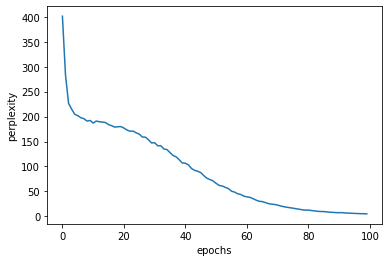

first ppl: 401.02, last  ppl: 4.98


In [8]:
x = np.arange(0, max_epoch, 1)
plt.plot(x, ppl_list)
plt.xlabel("epochs")
plt.ylabel('perplexity')
plt.show()
print('first ppl: %.2f, last  ppl: %.2f' %(ppl_list[0], ppl_list[-1]))

たしかにパープレキシティが小さくなっていることが分かる。はじめは400以上であったが、最終的には5程度になっている。コーパスサイズが小さいため5程度であるが、大きくしようとするとこのモデルではできない。

**参考文献**
1. ゼロから作るDeep Learning2 自然言語処理偏